In [1]:
import torch
from torch import nn
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import CosineAnnealingLR, MultiStepLR
import torchvision
from torchvision import transforms, utils, datasets

import os
import sys
if '/opt/ros/kinetic/lib/python2.7/dist-packages' in sys.path:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
import cv2
import h5py
import PIL
import numpy as np
import random
import logging
import gdown
from zipfile import ZipFile
import matplotlib.pyplot as plt

%matplotlib inline

## Parameters

In [2]:
BATCH_SIZE = 4
INPUT_IMG_SIZE = (101, 101)
EPOCH = 30                # train the training data n times, to save time, we just train 1 epoch
LR = 0.001               # learning rate
DATASET_ROOT = './YB_3class_60'
MODELS_ROOT = './models'
CLASSES = np.loadtxt('class_id.txt', str, delimiter='\n')

## Download dataset

In [3]:
test_dataset_url = 'https://drive.google.com/uc?id=1cKLNz86fd-20I-lMELVf2lUUvUbFGx-u'
test_dataset_name = 'YB_3class_60'
if not os.path.isdir(test_dataset_name):
    gdown.download(test_dataset_url, output=test_dataset_name + '.zip', quiet=False)
    zip1 = ZipFile(test_dataset_name + '.zip')
    zip1.extractall(test_dataset_name)
    zip1.close()

print 'Finished downloading testing dataset.'

Finished downloading testing dataset.


## Download pre-trained model

In [4]:
pretrain_model_url = 'https://drive.google.com/uc?id=1aSU1mg0qiFsgBw1p2-hd2bgv2WtQh2m_'
pretrain_model_name = 'trailnet_3class_real_vr_mix_color.h5'
if not os.path.isfile(os.path.join(MODELS_ROOT, pretrain_model_name)):
    if not os.path.isdir(MODELS_ROOT):
        os.mkdir(MODELS_ROOT)
    gdown.download(pretrain_model_url, output=os.path.join(MODELS_ROOT, pretrain_model_name), quiet=False)
    
print 'Finished downloading pre-trained model.'  

Finished downloading pre-trained model.


## Image loading methods

In [5]:
def pil_loader(path):
    with open(path, 'rb') as f:
        with PIL.Image.open(f) as img:
            return img.convert('RGB')

def accimage_loader(path):
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
        # Potentially a decoding problem, fall back to PIL.Image
        return pil_loader(path)

def default_loader(path):
    if torchvision.get_image_backend() == 'accimage':
        return accimage_loader(path)
    else:
        return pil_loader(path)

## Dataset preparation method #1
Use **DatasetFolder** provided by [torchvision.datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder)

In [6]:
def create_trailnet_dataloader(batch = BATCH_SIZE, shuffle=True):
    # The path to images folder 
    fpath = os.path.join('./YB_3class_60/YB_A1_60')
    
    # Data transformer
    data_transform = transforms.Compose([
            transforms.Resize(INPUT_IMG_SIZE),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], \
                                std=[1, 1, 1])
    ])
    
    # Image loader
    img_loader = datasets.DatasetFolder(root=fpath, \
                                        loader=default_loader, \
                                        transform=data_transform, \
                                        extensions='.jpg'
                                       )
    print('Amount of data: ' + str(len(img_loader)))
    
    # Pytorch dataset loader
    loader = torch.utils.data.DataLoader(dataset=img_loader, \
                                         batch_size=batch, \
                                         shuffle=shuffle)
    return loader

In [7]:
def vis_img(batch_data):   
    # show images
    imgs = torchvision.utils.make_grid(batch_data)
    imgs = imgs / 2 + 0.5     # unnormalize
    npimgs = imgs.numpy()
    plt.rcParams['figure.figsize'] = [12, 5]
    plt.imshow(np.transpose(npimgs, (1, 2, 0)))

Amount of data: 180
labels:[2 1 1 1]


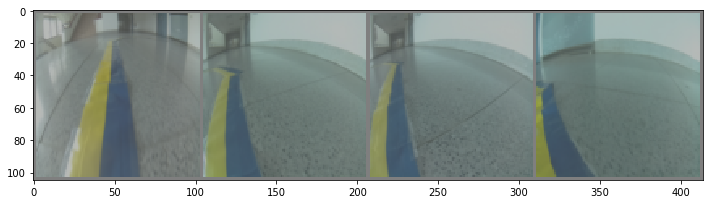

In [8]:
testdata_loader = create_trailnet_dataloader()
data_iter = iter(testdata_loader)
batch_data = data_iter.next()
vis_img(batch_data[0])

print('labels:' + str(batch_data[1].numpy()))

## Dataset preparation method #2
Create own dataset loader wtih following code strcture

```python
from torch.utils.data.dataset import Dataset

class customDataset(Dataset):
    def __init__(self):
        ##############################################
        ### Initialize paths, transforms, and so on
        ##############################################
        
    def __getitem__(self, index):
        ##############################################
        # 1. Read from file (using numpy.fromfile, PIL.Image.open)
        # 2. Preprocess the data (torchvision.Transform).
        # 3. Return the data (e.g. image and label)
        ##############################################
        
    def __len__(self):
        ##############################################
        ### Indicate the total size of the dataset
        ##############################################
```

In [9]:
def load_images_from_folder(folder, classes):
    img_paths = []
    labels = []
    for class_id, class_name in enumerate(classes):
        class_folder = os.path.join(folder, class_name)
        for filename in os.listdir(class_folder):
            filename.lower().endswith(('.png', '.jpg', '.jpeg'))
            img_paths.append(os.path.join(class_folder, filename))
            labels.append(class_id)
    return img_paths, labels

In [10]:
class TrailnetDataset(Dataset):
    def __init__(self, dataset_root):
        classes = CLASSES
        dataset_folders = self.collect_folders_from_dataset(dataset_root, classes)
        
        self.img_list = []
        self.label_list = []
        cnt = 0
        for p in dataset_folders:
            img_paths, labels = load_images_from_folder(p, classes)
            self.img_list.extend(img_paths)
            self.label_list.extend(labels)
            cnt += len(img_paths)
        print '********** Dataset Info start **********\n'
        print 'Dataset folder: ', dataset_folders
        print 'Output classes: ', classes
        print 'Amount of images: ', cnt
        print '\n*********** Dataset Info end ***********\n'
        
        self.data_transform = transforms.Compose([ 
                                transforms.Resize(INPUT_IMG_SIZE), \
                                transforms.ToTensor(), \
                                transforms.Normalize(mean=[0.5, 0.5, 0.5], \
                                                     std=[1, 1, 1]), \
                                ])

    def __len__(self):
        return len(self.img_list)
    
    def collect_folders_from_dataset(self, dataset_root, classes):
        # Implement by BFS
        search_list = [dataset_root, ]
        dataset_folders = [] 
        while len(search_list) != 0:
            root = search_list.pop(0)
            if set(os.listdir(root)) == set(classes):
                dataset_folders.append(root)
            else:
                for folder in os.listdir(root):
                    path = os.path.join(root, folder)
                    if os.path.isdir(path):
                        search_list.append(path)
        return dataset_folders

    def __getitem__(self, index):
        'Generates one sample of data'
        # print self.img_list[index]
        # Select sample, then load data and get label
        img_raw = self.default_loader(self.img_list[index])
        x = self.data_transform(img_raw)
        y = torch.tensor(self.label_list[index])
        return x, y
    
    def pil_loader(self, path):
        with open(path, 'rb') as f:
            with PIL.Image.open(f) as img:
                return img.convert('RGB')

    def accimage_loader(self, path):
        try:
            return accimage.Image(path)
        except IOError:
            # Potentially a decoding problem, fall back to PIL.Image
            return pil_loader(path)

    def default_loader(self, path):
        if torchvision.get_image_backend() == 'accimage':
            return self.accimage_loader(path)
        else:
            return self.pil_loader(path)

#### Dataset random loading test

********** Dataset Info start **********

Dataset folder:  ['./YB_3class_60/YB_B1_60', './YB_3class_60/YB_A2_60', './YB_3class_60/YB_D1_60', './YB_3class_60/YB_C1_60', './YB_3class_60/YB_A1_60', './YB_3class_60/YB_D2_60']
Output classes:  ['L' 'S' 'R']
Amount of images:  1080

*********** Dataset Info end ***********

<class 'torch.Tensor'> <class 'torch.Tensor'>
Image size:  torch.Size([3, 101, 101])
Ground true:  tensor(2)
Image: 


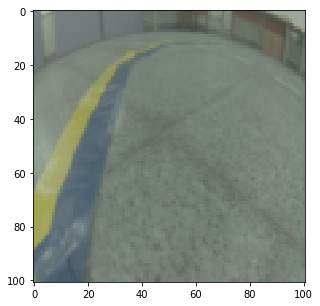

In [11]:
import random
dataset = TrailnetDataset(dataset_root=DATASET_ROOT)
img , l = random.choice(dataset)
print type(img),type(l)

print 'Image size: ', img.size()
print 'Ground true: ', l
print 'Image: '
vis_img(img)

# Model declare

In [13]:
class TrailNet3Class(nn.Module):

    def __init__(self):
        super(TrailNet3Class, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(3, 32, 4)
        self.pool1 = nn.MaxPool2d((2, 2), stride=2)
        self.conv2 = nn.Conv2d(32, 32, 4)
        self.pool2 = nn.MaxPool2d((2, 2), stride=2)
        self.conv3 = nn.Conv2d(32, 32, 4)
        self.pool3 = nn.MaxPool2d((2, 2), stride=2)
        self.conv4 = nn.Conv2d(32, 32, 4, padding=(2, 2))
        self.pool4 = nn.MaxPool2d((2, 2), stride=2)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(800, 200)
        self.fc2 = nn.Linear(200, 3)

    def forward(self, x):
        x = self.pool1(self.conv1(x))
        x = self.pool2(self.conv2(x))
        x = self.pool3(self.conv3(x)) 
        x = self.pool4(self.conv4(x))    
        # print 'x size: ', x.size()   
        x = x.view(-1, self.num_flat_features(x))
        # print 'x size: ', x.size()   
        x = self.fc1(x)
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

cudnn.benchmark = True

model = TrailNet3Class()
model.cuda()

state_dict = h5py.File(os.path.join(MODELS_ROOT, 'trailnet_3class_real_vr_mix_color.h5'), 'r')
model.load_state_dict({l : torch.from_numpy(np.array(v)).view_as(p) \
                     for k, v in state_dict.items() \
                     for l, p in model.named_parameters() if k in l})

<All keys matched successfully>

### Use [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) to pack our custom dataset

There are two type dataset inputs of torch.utils.data.DataLoader, **one is map-style** which implemented by 
inheriting [Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset), **the other one is iterable-style** implemented by inheriting [IterableDataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.IterableDataset).

In [14]:
test_dataset = TrailnetDataset(dataset_root=DATASET_ROOT)
dataset_loader = DataLoader(test_dataset, batch_size=2, num_workers=0, shuffle=False)

cnt = 0
for idx, (images, targets) in enumerate(dataset_loader):
    images, targets = images.cuda(), targets.cuda()
    output = model(images)
    pred = output.argmax(axis=1)
#     print 'ground true: ', pred
#     print 'pretiction : ', targets
    for i in range(len(targets)):
        if pred[i] == targets[i]:
            cnt = cnt + 1
print 'Accuracy: {:.2f} %'.format(float(cnt)/1080 * 100)

********** Dataset Info start **********

Dataset folder:  ['./YB_3class_60/YB_B1_60', './YB_3class_60/YB_A2_60', './YB_3class_60/YB_D1_60', './YB_3class_60/YB_C1_60', './YB_3class_60/YB_A1_60', './YB_3class_60/YB_D2_60']
Output classes:  ['L' 'S' 'R']
Amount of images:  1080

*********** Dataset Info end ***********

Accuracy: 86.94 %
